In [1]:
import ergo
from ergo.scale import Scale
import ergo.distributions as dist

import seaborn
import matplotlib.pyplot as plt

import jax.numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/Users/nix/Dropbox/Projects/Ergo/ergo/ergo/ppl.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def graph(D, bins=100):
    xs = np.linspace(D.ppf(0.01), D.ppf(0.99), bins)
    ys = [D.pdf(x) for x in xs]
    plt.plot(xs, ys)

In [3]:
def display_params(mixture):
    for i,c in enumerate(mixture.components):
        if hasattr(c, "base_dist"):
            c = c.base_dist
        print(f"Loc: {c.true_loc:3g} \t({c.loc:3g})",
              f"Scale: {c.true_s:3g} \t({c.s:3g})",
              f"Prob: {mixture.probs[i]:3g}",
             sep="\t")

In [4]:
def test_fit(lm):
    samples = np.array([lm.sample() for _ in range(0, 5000)])
    fit = dist.LogisticMixture.from_samples(samples, fixed_params={"num_components": 3},
                                        init_tries=200, opt_tries=3)
    
    graph(lm)
    graph(fit)
    
    plt.legend(["original ppf", "fit ppf"])
    
    print("original parameters:")
    display_params(lm)
    print("fit parameters:")
    display_params(fit)

The fitting works well in most cases:

original parameters:
Loc:  40 	(0.4)	Scale:  10 	(0.1)	Prob: 0.8
Loc:  70 	(0.7)	Scale:   3 	(0.03)	Prob: 0.2
fit parameters:
Loc: 69.9243 	(0.636215)	Scale: 3.04397 	(0.0122272)	Prob: 0.213537
Loc: 39.6277 	(0.514518)	Scale: 9.9456 	(0.03995)	Prob: 0.773275
Loc: 41.4893 	(0.521996)	Scale: 4.92042 	(0.0197646)	Prob: 0.0131882


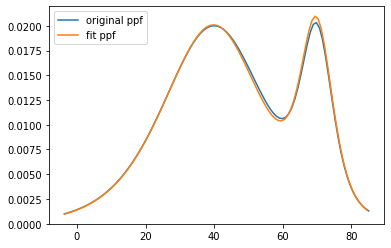

In [5]:
scale = Scale(0, 100)
lm = dist.LogisticMixture(
        components=[
            dist.Logistic(loc=40, s=10, scale=scale),
            dist.Logistic(loc=70, s=3, scale=scale),
        ],
        probs=[0.8, 0.2],
    )

test_fit(lm)

It fails in certain edge cases, however -- including with very narrow distributions:

original parameters:
Loc:  40 	(0.4)	Scale:  10 	(0.1)	Prob: 0.8
Loc:  70 	(0.7)	Scale: 0.5 	(0.005)	Prob: 0.2
fit parameters:
Loc: 69.3609 	(0.567473)	Scale: 2.92867 	(0.01)	Prob: 0.145184
Loc: 38.1099 	(0.460766)	Scale: 9.6108 	(0.0328163)	Prob: 0.749172
Loc: 69.3607 	(0.567472)	Scale: 2.92867 	(0.01)	Prob: 0.105644


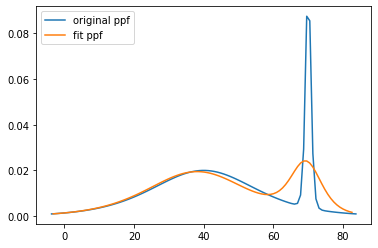

In [6]:
scale = Scale(0, 100)
lm = dist.LogisticMixture(
        components=[
            dist.Logistic(loc=40, s=10, scale=scale),
            dist.Logistic(loc=70, s=.5, scale=scale),
        ],
        probs=[0.8, 0.2],
    )

test_fit(lm)

I believe the specific bug above is 